In [2]:
import yt
import caesar
import matplotlib.pyplot as plt
import numpy as np
#import fsps
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
from readgadget.modules import header as HEAD
from readgadget.modules.common import *
from readgadget.modules.names import *
from readgadget.modules.hdf5 import *
import sys, os
import h5py

In [62]:
#snapshot = '/Volumes/ufrc/narayanan/s.lower/pd_runs/simba_m25n512/snap305_boxtest/filtered_snaps/snap305_galaxy003_filtered.hdf5'
caesar_snap = '/Volumes/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0305_z0.000.hdf5'

In [63]:
obj = caesar.quick_load(caesar_snap)
sim = obj
        

yt : [INFO     ] 2019-11-04 09:58:08,637 Reading /Volumes/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0305_z0.000.hdf5
yt : [INFO     ] 2019-11-04 09:58:08,984 Loading global lists
yt : [INFO     ] 2019-11-04 10:01:49,001 Loading halos
yt : [INFO     ] 2019-11-04 10:02:13,157 Loaded 83513 halos
yt : [INFO     ] 2019-11-04 10:02:13,158 Loading galaxies
yt : [INFO     ] 2019-11-04 10:02:18,838 Loaded 2463 galaxies


In [72]:
old_caesar = pd.read_pickle('/Users/sidneylower/Documents/snap305_dirichlet/caesar_galaxy_properties_evo2000.pkl')
ultra = pd.read_pickle('/Volumes/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/snap305_ultra_mist/dirichlet/bad_atten/prospectorsnap305_properties_Dirichlet_1572831027.4616585.pkl')

In [4]:
new_sfh = pd.read_pickle('/Volumes/ufrc/narayanan/s.lower/sfh_allprogen.pkl')

In [5]:
#simtime = sim.simulation.time.in_units('Gyr')
simtime = 13.86

In [154]:
galaxy = 450

In [155]:
c_timelist = list(dict.fromkeys(old_caesar.index.get_level_values('Time [Gyr]')))
c_sfrlist = old_caesar.loc[[galaxy]]['SFR']

In [156]:
ultra_timelist = list(dict.fromkeys(ultra.index.get_level_values('Time [Gyr]')))
ultra_sfrlist = list(dict.fromkeys(ultra.loc[['{0:03}'.format(galaxy)]]['SFR']))
ultra_sfr16 = list(dict.fromkeys(ultra.loc[['{0:03}'.format(galaxy)]]['SFR_16']))
ultra_sfr84 = list(dict.fromkeys(ultra.loc[['{0:03}'.format(galaxy)]]['SFR_84']))

In [157]:
new_timelist = np.asarray(list((dict.fromkeys(new_sfh.index.get_level_values('Time [Gyr]')))))
new_sfrlist = np.asarray(new_sfh.loc[[galaxy]]['SFR'])

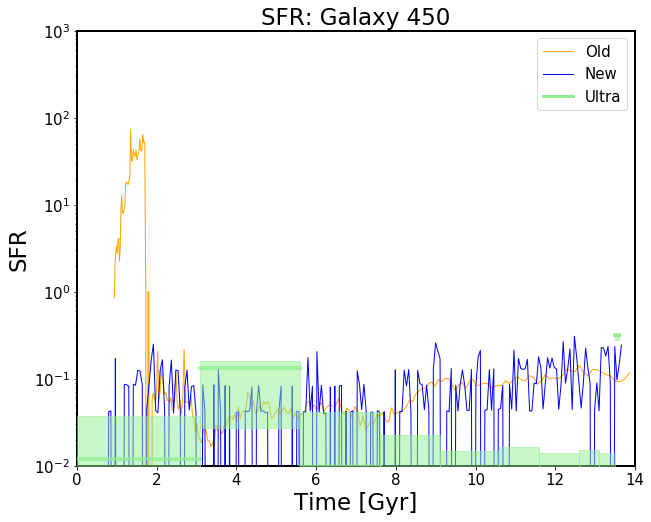

In [158]:
plt.figure(figsize=(10, 8))
plt.rc('axes', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
#plt.plot(simtime - sfr_bins[:len(sfr)], sfr, lw=1, label='New', zorder=1)
plt.plot(c_timelist, c_sfrlist, lw=1, color='orange', label='Old', zorder=0)
plt.plot(13.7 - new_timelist, new_sfrlist, lw=1, color='blue', label='New')

try:
    for i in range(10):
        plt.plot([ultra_timelist[i], ultra_timelist[i+1]], [ultra_sfrlist[i], ultra_sfrlist[i]], color='lightgreen', lw=4, alpha=0.7, zorder=5)
        plt.fill_between([ultra_timelist[i], ultra_timelist[i+1]], y1=ultra_sfr16[i], y2=ultra_sfr84[i], color='lightgreen', alpha=0.5, zorder=5)
    plt.plot([ultra_timelist[0],ultra_timelist[1]], [ultra_sfrlist[0], ultra_sfrlist[0]], color='lightgreen', lw=3, label='Ultra', zorder=5)
except: pass

plt.yscale('log')
plt.ylim([1e-2, 1e3])
plt.xlim([0, 14])
plt.ylabel('SFR', fontsize=23)
plt.xlabel('Time [Gyr]', fontsize=23)
plt.title('SFR: Galaxy '+str(galaxy), fontsize=23)
plt.legend(loc='best', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/prosp_final_plots/sfr_comp'+str(galaxy)+'.png', dpi=300, bbox_inches='tight')

In [159]:
fsps_years = np.linspace(0.01, 14, 250)
sfr_bins = fsps_years
sfr_times = [(j+i)/2 for i, j in zip(sfr_bins[:-1], sfr_bins[1:])]

In [160]:
sfr_times

[0.03809236947791164,
 0.09427710843373494,
 0.15046184738955823,
 0.20664658634538152,
 0.26283132530120484,
 0.3190160642570281,
 0.37520080321285143,
 0.4313855421686747,
 0.487570281124498,
 0.5437550200803214,
 0.5999397590361446,
 0.6561244979919678,
 0.7123092369477912,
 0.7684939759036145,
 0.8246787148594377,
 0.8808634538152611,
 0.9370481927710843,
 0.9932329317269077,
 1.049417670682731,
 1.1056024096385544,
 1.1617871485943776,
 1.2179718875502008,
 1.274156626506024,
 1.3303413654618474,
 1.3865261044176707,
 1.442710843373494,
 1.4988955823293173,
 1.5550803212851405,
 1.6112650602409637,
 1.6674497991967872,
 1.7236345381526106,
 1.7798192771084338,
 1.836004016064257,
 1.8921887550200802,
 1.9483734939759036,
 2.0045582329317266,
 2.0607429718875503,
 2.116927710843373,
 2.1731124497991967,
 2.22929718875502,
 2.285481927710843,
 2.341666666666667,
 2.3978514056224896,
 2.454036144578313,
 2.510220883534136,
 2.5664056224899596,
 2.6225903614457833,
 2.678775100401606,

In [ ]:
f